# CIFAR-10: Convolutional Neural Networks


This dataset contains 60,000 images. It has 10 different classes. THe images are 32x32X3. They are colored images. Because they are colored images we are going to use GPU. 
GPU allows data processing to be done in parallel which speeds up training time.

In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU...')
else:
    print('CUDA is available! Training on GPU...')

CUDA is available! Training on GPU...


In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))])

In [4]:
train_data = datasets.CIFAR10('data', train=True, download=True,
                             transform=transform)

test_data = datasets.CIFAR10('data', train=False, download=True, 
                            transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# number of processors to use for data loading
num_workers = 0

batch_size = 20

valid_size = 0.2


num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# preparing the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler=train_sampler, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         num_workers=num_workers)

In [6]:
# specifying the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog',
          'frog', 'horse', 'ship', 'truck']

In [7]:
images, labels = next(iter(train_loader))

In [8]:
def show_image(images, num_of_images):
    
    fig = plt.figure(figsize=(25,4))
    
    for index in range(num_of_images):
        img = images[index] / 2 + 0.5
        img = np.transpose(img, (1,2,0))
        
        ax = fig.add_subplot(2, num_of_images/2, index+1, xticks=[], yticks=[])
        plt.imshow(img)
        ax.set_title(classes[labels[index]])

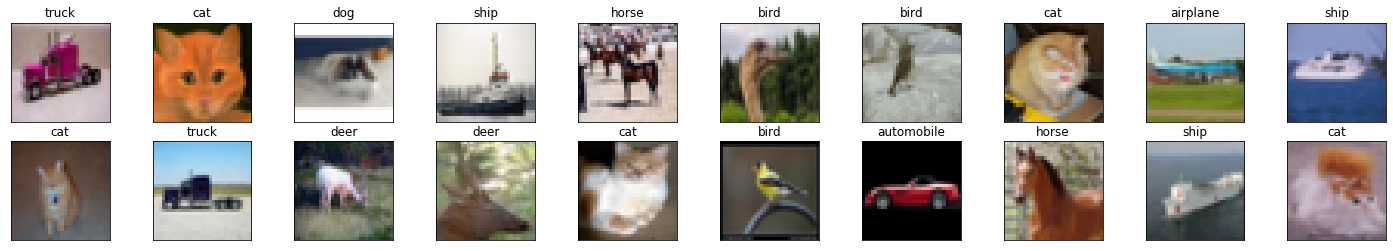

In [9]:
show_image(images, num_of_images=20)

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = Net()

In [19]:
model

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [20]:
# moving the tensors to GPU
if train_on_gpu:
    model.cuda()

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [22]:

epochs = 5

valid_loss_min = np.inf

for epoch in range(epochs):
    train_loss = 0
    valid_loss = 0
    
    model.train()
    for images, labels in train_loader:
        
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
            
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    # validating the model
    model.eval()
    for images, labels in valid_loader:
        
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        output = model(images)
        loss = criterion(output, labels)
        valid_loss += loss.item()
        
    # calculating the losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    
    print(f'Epoch: {epoch+1} \nTraining loss: {train_loss} \nValidation loss: {valid_loss}')
    
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f'Validation decreased from {valid_loss_min} to {valid_loss}.')
        print('Saving the model ...')
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
        

Epoch: 1 
Training loss: 0.10822613036632538 
Validation loss: 0.0940262727379799
Validation decreased from inf to 0.0940262727379799.
Saving the model ...
Epoch: 2 
Training loss: 0.08639102254211903 
Validation loss: 0.08092304544448853
Validation decreased from 0.0940262727379799 to 0.08092304544448853.
Saving the model ...
Epoch: 3 
Training loss: 0.07767077999711036 
Validation loss: 0.07563511983156204
Validation decreased from 0.08092304544448853 to 0.07563511983156204.
Saving the model ...
Epoch: 4 
Training loss: 0.07294040908962489 
Validation loss: 0.07107278066277505
Validation decreased from 0.07563511983156204 to 0.07107278066277505.
Saving the model ...
Epoch: 5 
Training loss: 0.06886039394885302 
Validation loss: 0.06887520672082902
Validation decreased from 0.07107278066277505 to 0.06887520672082902.
Saving the model ...


In [23]:
# loading the model with the lowest validation loss

model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [16]:
# Testing the model

test_loss = 0
class_correct = list(0 for i in range(10))
class_total = list(0 for i in range(10))

model.eval()
for images, labels in test_loader:
    
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
        
    output = model(images)
    loss = criterion(output, labels)
    test_loss += loss.item()
    
    # converting the outputed probabilities to predicted class
    _, pred = torch.max(output, 1)
    
    # comparing predictions to true label
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = 

SyntaxError: invalid syntax (<ipython-input-16-d29d7552ed52>, line 22)

In [32]:
test_img, test_label = next(iter(test_loader))

In [45]:
test_img, test_label = test_img.cuda(), test_label.cuda()

In [46]:
output = model(test_img)

In [58]:
output[0]

tensor([-0.8274, -1.8648,  1.7610,  2.4570, -0.4612,  1.8366,  0.7804, -0.9444,
        -1.6839, -1.1495], device='cuda:0', grad_fn=<SelectBackward>)

In [47]:
loss = criterion(output, test_label)

In [56]:
test_loss = 0

In [60]:
test_loss += loss.item()

In [65]:
_, pred = torch.max(output, 1)

ValueError: not enough values to unpack (expected 3, got 2)

In [63]:
_

tensor([2.4570, 5.8575, 3.9765, 3.3809, 3.9291, 2.5211, 2.3874, 3.4710, 3.6663,
        5.1518, 1.9328, 4.3314, 2.6232, 5.6652, 3.8513, 0.6999, 2.7656, 2.7596,
        3.9306, 3.1098], device='cuda:0', grad_fn=<MaxBackward0>)

In [64]:
pred

tensor([3, 1, 1, 0, 6, 6, 5, 4, 5, 1, 0, 9, 6, 7, 1, 4, 5, 5, 8, 6],
       device='cuda:0')